### Microbiology -- developing the arrays of results


In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import json
import re
from textwrap import wrap
import matplotlib.ticker
import os

idx = pd.IndexSlice

In [2]:
here = os.getcwd()
j_data = here + '/data/json/'

In [3]:
## open up the dfs
def get_jsons(file_name):
    a = pd.read_json(j_data + file_name, orient='index')
    return a

In [4]:
dfs = ['m_b_2016.json','m_b_2017.json', 'rain_2016.json','m_b_201724.json', 'm_b_201748.json', 'rain_2017.json']

In [5]:
m_b_2016 = get_jsons(dfs[0])
m_b_2017 = get_jsons(dfs[1])
rain_2016 = get_jsons(dfs[2])
m_b_201724 = get_jsons(dfs[3])
m_b_201748 = get_jsons(dfs[4])
rain_2017 = get_jsons(dfs[5])

In [6]:
# check how the tools work in this environment
# not the same function as before, removed index

def get_jsons_x(file_name):
    with open(j_data + file_name, 'r') as f:
        a = json.load(f)
    return a
date_week16 = get_jsons_x('date_week16.json')

In [7]:
week_date16 = get_jsons_x('week_date16.json')
colony_map_16 = get_jsons_x('colony_map_16.json')
three_plate_16 = get_jsons_x('three_plate_16.json')
# so now we need the weekly average per colony, per week, per location
# for that we need to call dates
week_date16 = get_jsons_x('week_date16.json')
date_week16 = get_jsons_x('date_week16.json')
places = get_jsons_x('places.json')
mediums = get_jsons_x('mediums.json')

In [8]:
m_b_2016.set_index(['Date', 'Location'], inplace=True)
m_b_2016.sort_index(axis=0, level='Date', ascending=True, inplace=True)
#m_b_2016[three_plate_16[0][1]][:3]#<----should now be sorted by date

In [9]:
a_color_week = m_b_2016.loc[idx[week_date16['Week one'], places[0]], three_plate_16[0]]#<----- by changing the index numbers change location and colony

In [10]:
# this will give all the values for a color group for the entire project:
# m_b_2016.loc[m_b_2016.Location == places [2], three_plate_16[3]]
a_color_week.apply('mean', axis=1)#<------ gives the average of the row

Date        Location
2016-06-21  MRD         0.666667
dtype: float64

In [11]:
a_color_week.apply('mean', axis=1).item()#<---- gives the number that we need

0.6666666666666666

In [12]:
# so now put this all together to create a list that has weekly average per colony, per week, per location

In [13]:
# iterate through the colonies:
def colony_avg(df, dates, place, plates):
    a = df.loc[idx[dates, place], plates]
    b = df.loc[idx[dates, place], 'P1_qty_sample'].item()
    c = 100/b 
    d = a.apply('mean', axis=1).item()
    if d == 0:
        d = 1/len(plates)
        f = colony_map_16[plates[0]]
        e = d*c
        return e, f, b
    elif d > 0:
        e =d*c
        f = 'none'
        return e, f, b

In [14]:
# iterate by week
def weekly_avg(df, dates, place, plat_s):
    d = []
    e = []
    for plates in plat_s:
        a, b, c = colony_avg(df, dates, place, plates)
        d.append(a)
        if b != 'none':
            e.append(b)
    f = ', '.join(e)
        
    return [{date_week16[dates]:d}, {'BDL':f}, {'dilution':c}]

In [15]:
# add admin data
def place_weekly_avg(df, dates, place, plat_s):
    a = weekly_avg(df, dates, place, plat_s)
    a.append({'num samps':len(plat_s[0])})
    return a


In [16]:
# group by place then week
def place_by_week(df, dates, places, plates):
    d = []
    for place in places:
        b = []
        for date in dates:            
            a= place_weekly_avg(df, date, place, plates)
            b.append(a)
        c = {place:b}
        d.append(c)
    return d
    
bar_charts = place_by_week(m_b_2016, list(date_week16.keys()), places[:], three_plate_16)
bar_charts[0]['MRD'][0][0]#<--- gives the average colony count per group/week/location---

{'Week one': [66.66666666666666,
  466.6666666666667,
  100.0,
  266.66666666666663,
  33.33333333333333]}

In [17]:
bar_charts[0]['MRD'][0][1]#<--- changing this number gives other data

{'BDL': 'other'}

In [18]:
bar_charts[0]['MRD'][0][2]

{'dilution': 1.0}

In [19]:
bar_charts[0]['MRD'][0][3]

{'num samps': 3}

In [20]:
os.listdir(here+ '/data/images')

['array_2017.png',
 'tot_bblu_17.png',
 'jazz_dif.svg',
 'tot_uv_17.png',
 'array_2016_av.svg',
 'array_2016_av.png',
 'hotel_dif.svg',
 'tot_cfu_16.png',
 'array_2017.svg',
 'rain_dif.svg']

In [21]:
# start the function
def plot_ez_totals_2016(x, svgtitle, pngtitle):
    # number of rows depends on the number of weeks
    rows = len(list(week_date16.keys()))
    weeks_l = list(week_date16.keys())
    # the number of columns depends on the number of locations
    cols = len(x) +1
    # this is the number of bars in each chart
    # this depends on the number of color groups
    ind = np.arange(5)#<--- this can be made a variable
    # the width of each bar
    # width one means there is no space between bars
    width = 1
    # assign appropriate colors per grop
    # note the index number of each color matches the index number of the values from the first fucntion
    colss = ['darkblue', 'dodgerblue', 'turquoise', 'pink', 'lightslategray']
    # set up the figure and the array of charts
    f, axar = plt.subplots(rows, cols, figsize=(17,22))
    # create some space in between the rows for x axis labels, and titles
    f.subplots_adjust(hspace=0.9, wspace=0.2)
    # run through the results generated by the previous fucntion
    for i, n in enumerate(x):
        # indentify the first column
        # assign a special value 'week number'
        if i == 0:
            # the values are stored in a list of dicts
            # so calling x[i] gives a dict
            for key, value in x[i].items():
                # the key is the place name
                # the value is the list of results
                # run through the list of results
                for j, k in enumerate(value):
                    # if i is zero (the first set of results)
                    # then the week number needs to be printed first
                    # because the first column is the week indentifier
                    axar[j, i].text(0, 0.5, weeks_l[j], fontsize=14)
                    axar[j, i].set_axis_off()
                    # if object in value is a dict then print it out
                    # numerical values were stored in a list
                    if type(k[0][weeks_l[j]]) == dict:
                        axar[j, i+1].text(0.2, 0.5, k[0][weeks_l[j]]['no_test'], fontsize=10)
                        axar[j, i+1].set_title(key)
                        
                    # plot the numercal values in a bar chart
                    else:
                        # the i+1 shifts the column over..
                        # notice the values are called using the same variable as the week number column
                        # k[0][weeks_l[j]] <---- this is the list of color group averages per day
                        axar[j, i+1].bar(ind, k[0][weeks_l[j]], width, color=colss)
                        # the variable key is the place name,
                        # str(list(k[2].values())[0]) <--- this is the number of samples
                        # str(list(k[3].values())[0]) < ---- this is the dose 
                        axar[j, i+1].set_title(key + ', samples: ' + str(list(k[3].values())[0]) + ', ' + str(list(k[2].values())[0]) + 'mL', loc='left')
                        # set the xaxis lable by calling any resluts below detectable limit
                        # list(k[1].values())[0] < ---- this the 'bdl' string
                        axis_label = '\n'.join(wrap(list(k[1].values())[0], 33))
                        axar[j, i+1].set_xlabel(list(k[1].keys())[0] +': '+ axis_label)
                        # set the max and the ming for the axis
                        if max(k[0][weeks_l[j]]) == 25:
                            axar[j, i+1].set_ylim(0, max(k[0][weeks_l[j]]) + 75)
                        else:
                            axar[j, i+1].set_ylim(0, max(k[0][weeks_l[j]]) + 10)
        # rinse and repeat for column values not equal to zero
        else:
            for key, value in x[i].items():
                for j, k in enumerate(value):
                    if type(k[0][weeks_l[j]]) == dict:
                        axar[j, i+1].text(0.2, 0.5, k[0][weeks_l[j]]['no_test'], fontsize=10)
                        axar[j, i+1].set_title(key)
                       
                    else:
                        axar[j, i+1].bar(ind,  k[0][weeks_l[j]],width, color=colss)
                        axar[j, i+1].set_title(key + ', samples: ' + str(list(k[3].values())[0]) + ', ' + str(list(k[2].values())[0]) +'mL', loc='left')
                        axis_label = '\n'.join(wrap(list(k[1].values())[0], 33))
                        axar[j, i+1].set_xlabel(list(k[1].keys())[0] +': '+ axis_label)
                        if max(k[0][weeks_l[j]]) == 25:
                            axar[j, i+1].set_ylim(0, max(k[0][weeks_l[j]]) + 75)
                        else:
                            axar[j, i+1].set_ylim(0, max(k[0][weeks_l[j]]) + 10)
                    
    
    plt.savefig(svgtitle)
    plt.savefig(pngtitle)
    
    plt.show()

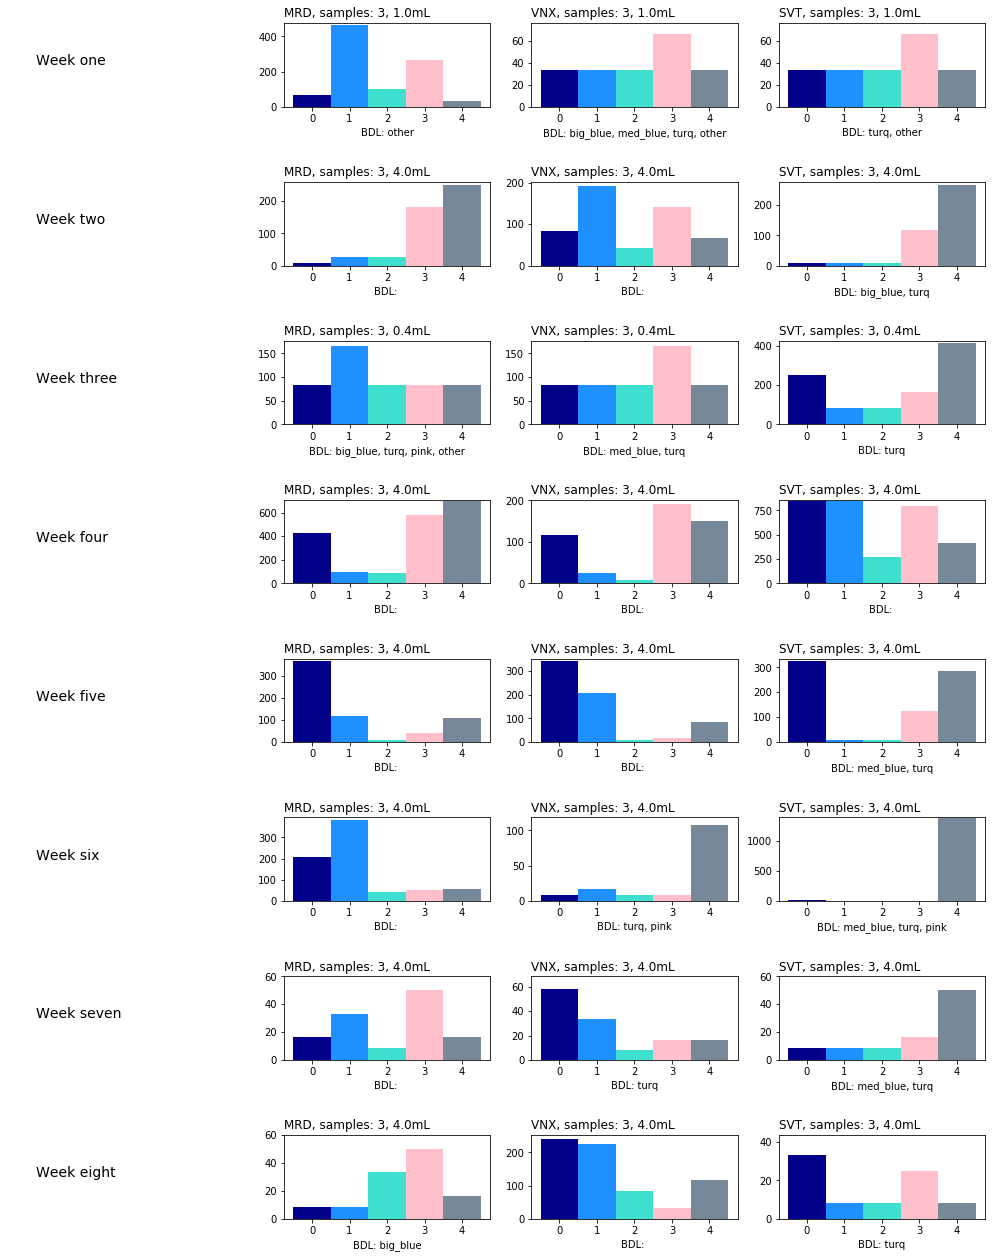

In [22]:
plot_ez_totals_2016(bar_charts,here + '/data/images/array_2016_av.svg', here + '/data/images/array_2016_av.png' )

In [23]:
m_b_201724.set_index(['Date', 'Location'], inplace=True)
m_b_201724.sort_index(axis=0, level='Date', ascending=True, inplace=True)

In [24]:
week_date = get_jsons_x('week_date.json')
date_week = get_jsons_x('date_week.json')
three_p_24_17 = get_jsons_x('three_p_24_17.json')
colony_map = get_jsons_x('colony_map.json')

In [25]:
colony_map_17_24 = {'P1_24h_big_blue': 'big_blue',
                    'P1_fluo_halo_colonies': 'UV Fluo',
                    'P1_24h_med_blue': 'med_blue',
                    'P1_24h_turq': 'turq',
                    'P1_24h_green': 'green',
                    'P1_24h_pink': 'pink',
                    'P1_24h_other': 'other',
                    'P2_24h_big_blue': 'big_blue',
                    'P2_fluo_halo_colonies': 'UV Fluo',
                    'P2_24h_med_blue': 'med_blue',
                    'P2_24h_turq': 'turq',
                    'P2_24h_green': 'green',
                    'P2_24h_pink': 'pink',
                    'P2_24h_other': 'other',
                    'P3_24h_big_blue': 'big_blue',
                    'P3_fluo_halo_colonies': 'UV Fluo',
                    'P3_24h_med_blue': 'med_blue',
                    'P3_24h_turq': 'turq',
                    'P3_24h_green': 'green',
                    'P3_24h_pink': 'pink',
                    'P3_24h_other': 'other'}


In [26]:
def colony_avg_17(df, dates, place, plates):
    a = df.loc[idx[dates, place], plates]
    #print(a)
    b = df.loc[idx[dates, place], 'P1_qty_sample'].item()
    g = df.loc[idx[dates, place], 'Samples'].item()
    c = 100/b 
    #print(a)
    d = a.apply('mean', axis=1).item()
    if g == 0:
        e = 0
        f = 'no sample'
        return e, f, b, g        
    elif d == 0:
        d = 1/len(plates)
        f = colony_map_17_24[plates[0]]
        e = d*c
        return e, f, b, g
    elif d > 0:
        e =d*c
        f = 'none'
        return e, f, b, g

In [27]:
# iterate by week
def weekly_avg_17(df, dates, place, plat_s):
    d = []
    e = []
    for plates in plat_s:
        a, b, c, g = colony_avg_17(df, dates, place, plates)
        d.append(a)
        if b != 'none':
            e.append(b)
    if g == 0:
        f = e[0]
    elif g != 0:
        f = ', '.join(e)
        
    return [{date_week[dates]:d}, {'BDL':f}, {'dilution':c}, {'num samps':g}]

In [28]:
# add admin data
def place_weekly_avg_17(df, dates, place, plat_s):
    #for place in places:
    a = weekly_avg_17(df, dates, place, plat_s)
    
    
    return a


In [29]:
# group by place then week
def place_by_week_17(df, dates, places, plates):
    d = []
    for place in places:
        b = []
        for date in dates:            
            a= place_weekly_avg_17(df, date, place, plates)
            #print(a)
            b.append(a)
        #print(place)
        c = {place:b}
        #print(c)
        d.append(c)
    #print(d)
    return d
    

In [30]:
a_i = m_b_201724.loc[m_b_201724.medium == 'easy_gel'].copy()

In [31]:
a_i.loc[idx['2017-07-24','MRD'], 'Samples'] = 0

In [32]:
bar_chart_17 = place_by_week_17(a_i, list(date_week.keys()), places[:], three_p_24_17)

In [33]:
# will need this for the x axis labels
from textwrap import wrap
# start the function
def plot_ez_totals(x, svgtitle, pngtitle):
    # number of rows depends on the number of weeks
    rows = len(list(week_date.keys()))
    weeks_l = list(week_date.keys())
    # the number of columns depends on the number of locations
    cols = len(x) +1
    # this is the number of bars in each chart
    # this depends on the number of color groups
    ind = np.arange(7)#<--- this can be made a variable
    # the width of each bar
    # width one means there is no space between bars
    width = 1
    # assign appropriate colors per grop
    # note the index number of each color matches the index number of the values from the first fucntion
    colss = ['darkviolet','darkblue', 'dodgerblue', 'green', 'turquoise', 'pink', 'lightslategray']
    # set up the figure and the array of charts
    f, axar = plt.subplots(rows, cols, figsize=(18,20))
    # create some space in between the rows for x axis labels, and titles
    f.subplots_adjust(hspace=0.9, wspace=0.3)
    # run through the results generated by the previous fucntion
    for i, n in enumerate(x):
        # indentify the first column
        # assign a special value 'week number'
        if i == 0:
            # the values are stored in a list of dicts
            # so calling x[i] gives a dict
            for key, value in x[i].items():
                # the key is the place name
                # the value is the list of results
                # run through the list of results
                for j, k in enumerate(value):
                    #print(k[3])
                    # if i is zero (the first set of results)
                    # then the week number needs to be printed first
                    # because the first column is the week indentifier
                    axar[j, i].text(0, 0.5, weeks_l[j], fontsize=14)
                    axar[j, i].set_axis_off()
                    # if object in value is a dict then print it out
                    # numerical values were stored in a list
                    if type(k[0][weeks_l[j]]) == dict:
                        axar[j, i+1].text(0.2, 0.5, k[0][weeks_l[j]]['no_test'], fontsize=10)
                        axar[j, i+1].set_title(key)
                        
                    # plot the numercal values in a bar chart
                    else:
#                       
                        # the i+1 shifts the column over..
                        # notice the values are called using the same variable as the week number column
                        # k[0][weeks_l[j]] <---- this is the list of color group averages per day
                        axar[j, i+1].bar(ind, k[0][weeks_l[j]], width, color=colss)
                        # the variable key is the place name,
                        # str(list(k[2].values())[0]) <--- this is the number of samples
                        # str(list(k[3].values())[0]) < ---- this is the dose 
                        axar[j, i+1].set_title(key + ', samples: ' + str(list(k[3].values())[0]) + ', ' + str(list(k[2].values())[0]) + 'mL')
                        # set the xaxis lable by calling any resluts below detectable limit
                        # list(k[1].values())[0] < ---- this the 'bdl' string
                        axis_label = '\n'.join(wrap(list(k[1].values())[0], 33))
                        axar[j, i+1].set_xlabel(list(k[1].keys())[0] +': '+ axis_label)
                        # set the max and the ming for the axis
                        if max(k[0][weeks_l[j]]) == 25:
                            axar[j, i+1].set_ylim(0, max(k[0][weeks_l[j]]) + 75)
                        else:
                            axar[j, i+1].set_ylim(0, max(k[0][weeks_l[j]]) + 10)
        # rinse and repeat for column values not equal to zero
        else:
            for key, value in x[i].items():
                for j, k in enumerate(value):
                    if type(k[0][weeks_l[j]]) == dict:
                        axar[j, i+1].text(0.2, 0.5, k[0][weeks_l[j]]['no_test'], fontsize=10)
                        axar[j, i+1].set_title(key)
                       
                    else:
                        axar[j, i+1].bar(ind,  k[0][weeks_l[j]],width, color=colss)
                        axar[j, i+1].set_title(key + ', samples: ' + str(list(k[3].values())[0]) + ', ' + str(list(k[2].values())[0]) +'mL')
                        axis_label = '\n'.join(wrap(list(k[1].values())[0], 33))
                        axar[j, i+1].set_xlabel(list(k[1].keys())[0] +': '+ axis_label)
                        if max(k[0][weeks_l[j]]) == 25:
                            axar[j, i+1].set_ylim(0, max(k[0][weeks_l[j]]) + 75)
                        else:
                            axar[j, i+1].set_ylim(0, max(k[0][weeks_l[j]]) + 10)
                  
    plt.savefig(svgtitle)
    plt.savefig(pngtitle)
    plt.show()

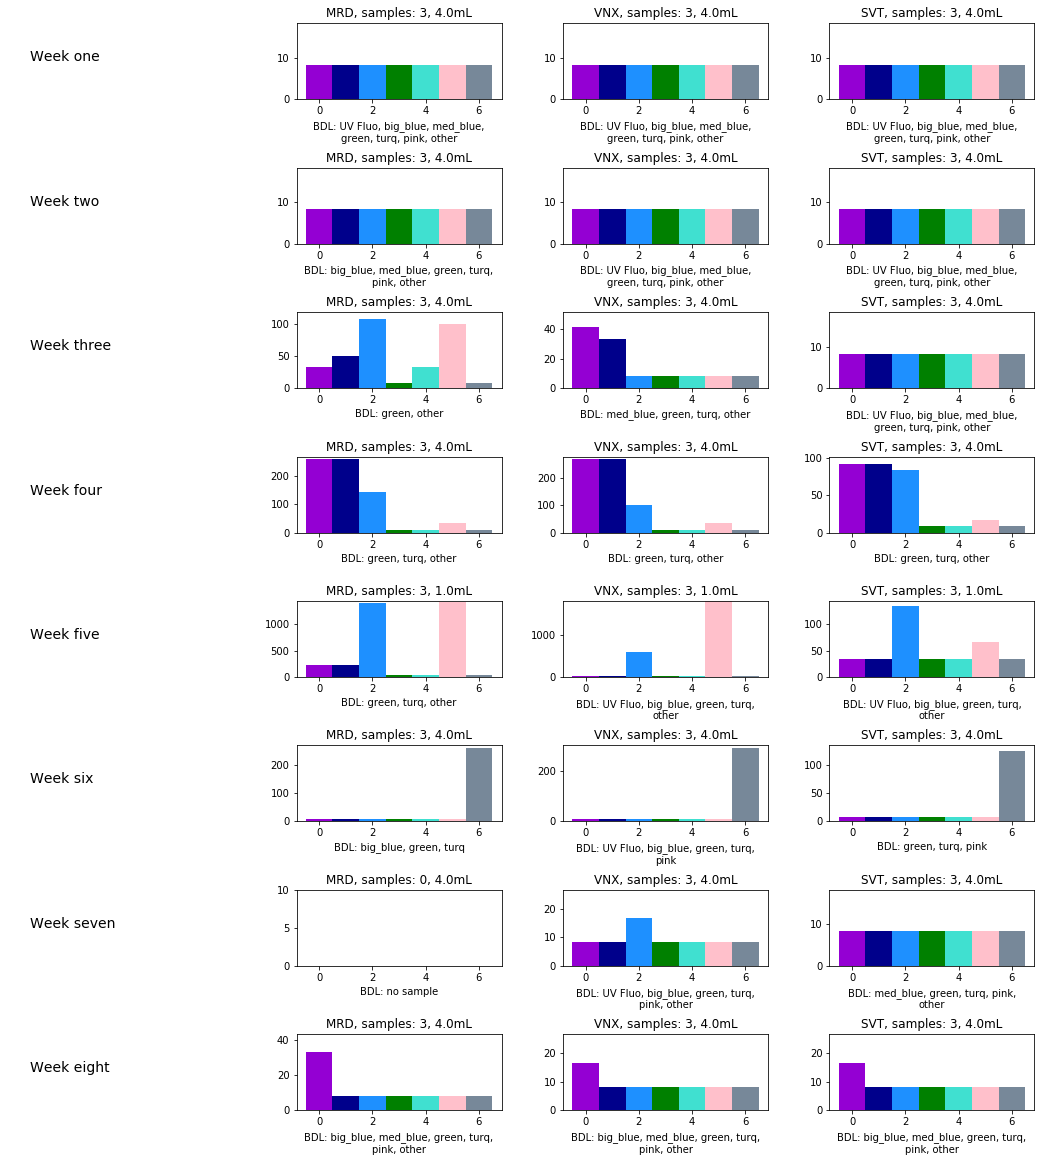

In [34]:
plot_ez_totals(bar_chart_17, here + '/data/images/array_2017.svg', here + '/data/images/array_2017.png')